In [4]:
# pip install pyarrow graphviz

In [5]:
import graphviz
from pgmpy.base import DAG
from networkx import is_d_separator

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

pd.set_option('display.max_columns', None)

In [6]:
cwd = Path.cwd() / 'hoopR'

team_path = cwd / 'team_box_2026.parquet'
player_path = cwd / 'player_box_2026.parquet'
schedule_path = cwd / 'mbb_schedule_2026.parquet'
play_by_play_path = cwd / 'play_by_play_2026.parquet'

In [7]:
def read_hoopR_parquets(path_list):
    return [pq.read_table(p).to_pandas() for p in path_list]

team_df, player_df, sched_df, pbp_df = read_hoopR_parquets([team_path, player_path, schedule_path, play_by_play_path])

In [8]:
team_cols = ['game_id', 'team_id', 'opponent_team_id', 'fouls']
switch_cols = {'team_id': 'opponent_team_id', 'opponent_team_id': 'team_id', 'fouls': 'opponent_fouls'}

team_df = team_df[team_cols].rename(columns=switch_cols)
team_df.head()

,game_id,opponent_team_id,team_id,opponent_fouls
0,401829220,2539,2541,14
1,401829220,2541,2539,20
2,401825477,26,2483,13
3,401825477,2483,26,17
4,401830830,36,21,13


In [9]:
player_cols = ['game_id', 'team_id', 'opponent_team_id', 'home_away', 'athlete_id', 'athlete_display_name', 'athlete_position_name', 'team_display_name', 'minutes', 'free_throws_attempted', 'free_throws_made']

player_df = player_df[player_cols]
player_df.head()

,game_id,team_id,opponent_team_id,home_away,athlete_id,athlete_display_name,athlete_position_name,team_display_name,minutes,free_throws_attempted,free_throws_made
0,401829220,2539,2541,away,5176426.0,Junjie Wang,Forward,San Francisco Dons,25.0,2.0,2.0
1,401829220,2539,2541,away,5174624.0,David Fuchs,Forward,San Francisco Dons,16.0,1.0,1.0
2,401829220,2539,2541,away,5176425.0,Ryan Beasley,Guard,San Francisco Dons,31.0,4.0,3.0
3,401829220,2539,2541,away,5101799.0,Legend Smiley,Guard,San Francisco Dons,17.0,0.0,0.0
4,401829220,2539,2541,away,5037875.0,Tyrone Riley IV,Guard,San Francisco Dons,26.0,0.0,0.0


In [ ]:
df = pd.merge(team_df, player_df, how='inner', on=['game_id', 'opponent_team_id', 'team_id'])
df['home_away'] = [1 if record == 'home' else 0 for record in df['home_away']] # 1 if home, 0 if away

# You don't want to know how long I banged my head on my desk not realizing I was dividing by 0 without this line of code:
df = df[df['free_throws_attempted'] > 0]

df['free_throw_pct'] = df['free_throws_made'] / df['free_throws_attempted']
df.dropna(inplace=True)
df.head()

,game_id,opponent_team_id,team_id,opponent_fouls,home_away,athlete_id,athlete_display_name,athlete_position_name,team_display_name,minutes,free_throws_attempted,free_throws_made,free_throw_pct
0,401829220,2539,2541,14,1,5241069.0,Elijah Mahi,Forward,Santa Clara Broncos,30.0,2.0,2.0,1.000000
1,401829220,2539,2541,14,1,5176361.0,Bukky Oboye,Center,Santa Clara Broncos,14.0,3.0,2.0,0.666667
2,401829220,2539,2541,14,1,5176359.0,Christian Hammond,Guard,Santa Clara Broncos,31.0,2.0,1.0,0.500000
5,401829220,2539,2541,14,1,5149115.0,Allen Graves,Forward,Santa Clara Broncos,25.0,4.0,3.0,0.750000
9,401829220,2539,2541,14,1,5147928.0,Thierry Darlan,Guard,Santa Clara Broncos,12.0,2.0,2.0,1.000000


Count HOME games: 23993
Count AWAY games: 21331


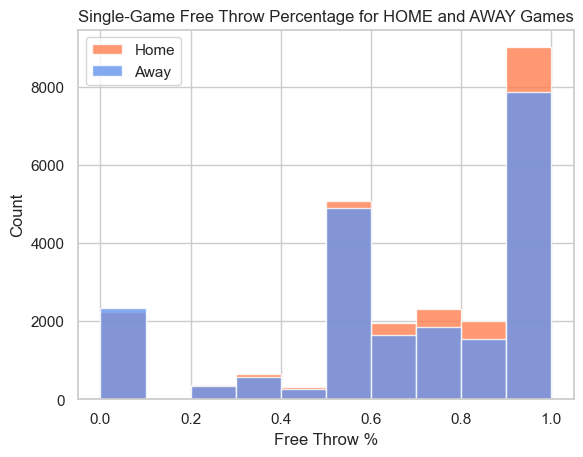

In [96]:
import matplotlib.pyplot as plt
home = df[df['home_away'] == 1]
away = df[df['home_away'] == 0]

print(f"Count HOME games: {len(home)}")
print(f"Count AWAY games: {len(away)}")

plt.hist(home['free_throw_pct'], alpha=0.8, color='coral', label='Home')
plt.hist(away['free_throw_pct'], alpha=0.8, color='cornflowerblue', label='Away')

plt.title('Single-Game Free Throw Percentage for HOME and AWAY Games')
plt.xlabel('Free Throw %')
plt.ylabel('Count')
plt.legend()
plt.show()

In [55]:
graphviz_graph = """
digraph {
    graph [rankdir=LR, splines=curved];
    node [shape=box, style="filled,rounded", fillcolor="#f0f0f0"];

    "Home/Away" -> FreeThrows_Made;
    MinutesPlayed -> FreeThrow_Attempts -> "FreeThrow_%";
    OpponentFouls -> FreeThrow_Attempts -> FreeThrows_Made -> "FreeThrow_%";
}
"""

dot = graphviz.Source(graphviz_graph)
dot.render('graphviz_graph', view=True, format='png')

'graphviz_graph.png'

<img src="graphviz_graph.png" width="700" />

In [56]:
dag = DAG(
    [('minutes','free_throws_attempted'),
     ('opponent_fouls','free_throws_attempted'),
     ('home_away','free_throws_made'),
     ('free_throws_attempted','free_throws_made'),
     ('free_throws_attempted','free_throw_pct'),
     ('free_throws_made','free_throw_pct')
    ]
)

In [57]:
dseps = dag.get_independencies()
dseps

(home_away ⟂ minutes)
(free_throw_pct ⟂ minutes | free_throws_attempted)
(opponent_fouls ⟂ free_throw_pct | free_throws_attempted)
(free_throw_pct ⟂ home_away | free_throws_made, free_throws_attempted)
(minutes ⟂ free_throws_made | free_throws_attempted)
(home_away ⟂ free_throws_attempted)
(opponent_fouls ⟂ free_throws_made | free_throws_attempted)
(opponent_fouls ⟂ minutes)
(opponent_fouls ⟂ home_away)

In [58]:
from pgmpy.estimators.CITests import chi_square
from pgmpy.independencies import IndependenceAssertion

def test_dsep(dsep):
    test_outputs = []
    for X in list(dsep.get_assertion()[0]):
        for Y in list(dsep.get_assertion()[1]):
            Z = list(dsep.get_assertion()[2])
            test_result = chi_square(
                X=X, Y=Y, Z=Z,
                data=df,
                boolean=True,
                significance_level=0.5
            )
            assertion = IndependenceAssertion(X, Y, Z)
            test_outputs.append((assertion, test_result))
    return test_outputs

In [59]:
results = [test_dsep(dsep) for dsep in dseps.get_assertions()]
results = dict([item for sublist in results for item in sublist])
results

{(home_away ⟂ minutes): np.False_,
 (free_throw_pct ⟂ minutes | free_throws_attempted): np.False_,
 (opponent_fouls ⟂ free_throw_pct | free_throws_attempted): np.False_,
 (free_throw_pct ⟂ home_away | free_throws_made, free_throws_attempted): np.False_,
 (minutes ⟂ free_throws_made | free_throws_attempted): np.False_,
 (home_away ⟂ free_throws_attempted): np.False_,
 (opponent_fouls ⟂ free_throws_made | free_throws_attempted): np.False_,
 (opponent_fouls ⟂ minutes): np.False_,
 (opponent_fouls ⟂ home_away): np.False_}

In [60]:
num_pass = sum(results.values())
num_dseps = len(dseps.independencies)
num_fail = num_dseps - num_pass
print(num_fail / num_dseps)


1.0


# Using DoWhy

In [61]:
# pip install dowhy econml

In [62]:
import dowhy
import econml

In [63]:
graph = """
digraph {
    home_away -> free_throws_made 
    minutes -> free_throws_attempted -> free_throw_pct
    opponent_fouls  -> free_throws_attempted -> free_throws_made  -> free_throw_pct
}
"""

In [73]:
# With graph
model = dowhy.CausalModel(
        data=df,
        treatment="home_away",
        outcome="free_throw_pct",
        graph=graph
        )

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['home_away'] on outcome ['free_throw_pct']


INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


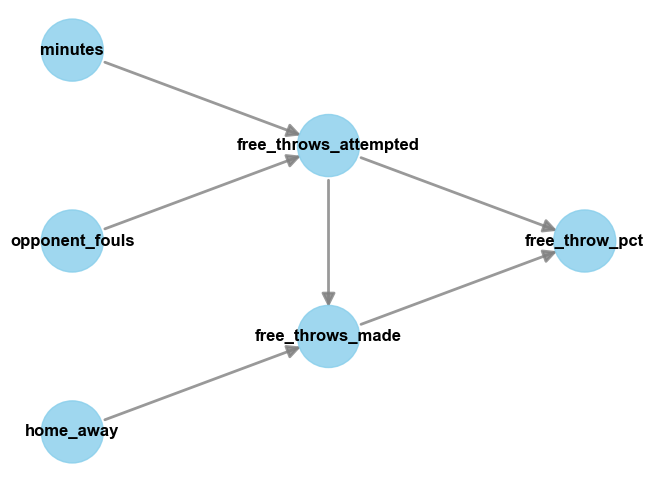

In [74]:
model.view_model()

In [75]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Number of general adjustment sets found: 1
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)



In [92]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: free_throw_pct~home_away | opponent_fouls,minutes,free_throws_attempted
c:\Users\amgal\Documents\Data Science\MSDS 452-DL\dag_nabbit\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\amgal\Documents\Data Science\MSDS 452-DL\dag_nabbit\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)

## Realized estimand
b: free_throw_pct~home_away | opponent_fouls,minutes,free_throws_attempted
Target units: ate

## Estimate
Mean value: 0.020992752020562166
Effect estimates: [[0.02465079]
 [0.02649866]
 [0.02442181]
 ...
 [0.02690802]
 [0.02667904]
 [0.027382  ]]



In [79]:
dml_estimate.value